Обучим модель XGBoost на индексах качества воздуха загрязнителей.

In [1]:
!pip install flake8 pycodestyle_magic

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.8/57.8 KB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.3/41.3 KB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 KB 4.1 MB/s eta 0:00:00


In [2]:
%load_ext pycodestyle_magic

In [3]:
%pycodestyle_on

In [4]:
# Ипортируем необходимые модули
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
import glob

from sklearn.metrics import mean_squared_error, mean_absolute_error
from pandas import DataFrame
from pandas import concat

In [8]:
# Скачивание данныъх
data = pd.read_csv("https://raw.githubusercontent.com/dmitry-chvdr/aqi_prediction/Checkpoint4/ts_air_quality_index_2013_2020.csv")


# Разбиваем на трейн тест
x_train = data.iloc[:-80]
x_test = data.iloc[-80:]

y_train = data['aqi'].iloc[:-80]
y_test = data['aqi'].iloc[-80:]

df = data[["CO_index", "PM10_index", "PM2.5_index"]]

INFO:pycodestyle:2:80: E501 line too long (130 > 79 characters)


In [9]:
# Преобразуем исходнные данные для построения модели на всех "подиндексах" качества воздуха.
data1 = x_train[["aqi", "CO_index", "PM10_index", "PM2.5_index"]]
data2 = x_test[["aqi", "CO_index", "PM10_index", "PM2.5_index"]]

# Формируем тренировочный и тестовый датасеты
df_xtrain = data1[["CO_index", "PM10_index", "PM2.5_index"]]
df_xtest = data2[["CO_index", "PM10_index", "PM2.5_index"]]

# Cформируем датасеты для построения временного окна
dfxtrain = DataFrame()
dfxtest = DataFrame()

# Выполняет построение временного окна путем сдвига исходного датасета
# Train
for column in df_xtrain:
    dfxtrain[f'{column}'] = df_xtrain[column].shift(1)
for column in df_xtrain:
    dfxtrain[f'{column}2'] = df_xtrain[column].shift(2)

# Test
for column in df_xtest:
    dfxtest[f'{column}'] = df_xtest[column].shift(1)
for column in df_xtest:
    dfxtest[f'{column}2'] = df_xtest[column].shift(2)

# Конвертируем исходные массив NumPy с ответами в Датафрейм для объединения
y_train = DataFrame(y_train)
y_test = DataFrame(y_test)

# Сформируем объединенный датасет 'сдвинутые индексы качесва воздуха' - 'True values'
# (Делаем это для сохранения соответсвия между подиндексами и реальным индексом качества воздуха)
frames1 = [y_train, dfxtrain]
frames2 = [y_test, dfxtest]

results1 = concat(frames1, axis=1)
results1 = results1.dropna()

results2 = concat(frames2, axis=1)
results2 = results2.dropna()

# Cформируем заключительный датасет трейн и тест
# Train
y_train = DataFrame(results1['aqi'])
x_train = results1

# Test
y_test = DataFrame(results2['aqi'])
x_test = results2

del x_train['aqi']
del x_test['aqi']

INFO:pycodestyle:1:80: E501 line too long (92 > 79 characters)
INFO:pycodestyle:30:80: E501 line too long (85 > 79 characters)
INFO:pycodestyle:31:80: E501 line too long (97 > 79 characters)


Выполним обучение XGBBost.

In [10]:
reg = xgb.XGBRegressor(n_estimators=100)
reg.fit(x_train, y_train,
        eval_set=[(x_train, y_train), (x_test, y_test)],
        early_stopping_rounds=10,
       verbose=False)

[17:29:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor()

INFO:pycodestyle:5:8: E128 continuation line under-indented for visual indent


Оценим важность признаков.

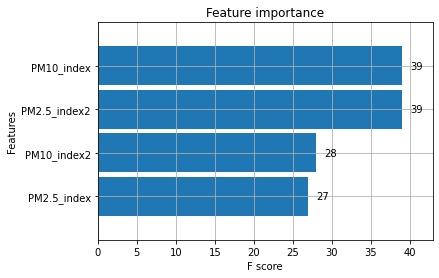

In [11]:
_ = xgb.plot_importance(reg, height=0.9)

Визуализируем соответсвие предсказанных данных и исходного временного ряда

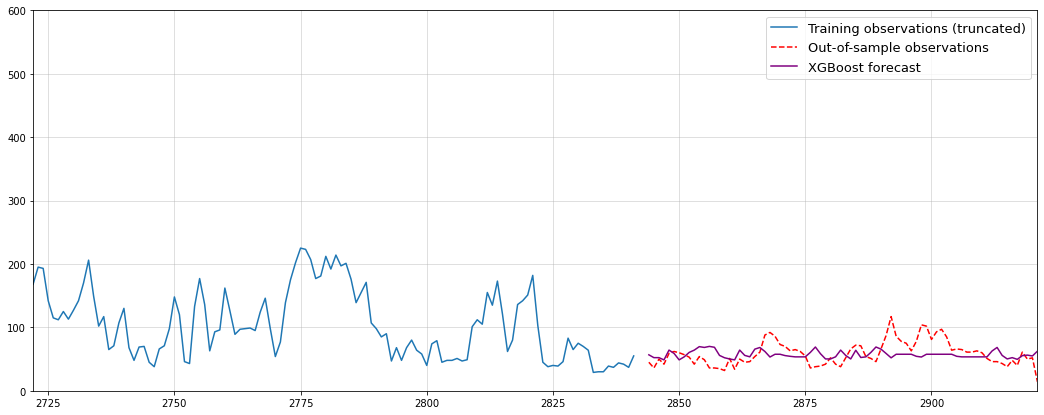

INFO:pycodestyle:12:80: E501 line too long (85 > 79 characters)


In [14]:
# Формирование предсказания
prediction = reg.predict(x_test)
results = DataFrame(y_test)
results['Prediction'] = prediction

# Визуализация
plt.figure(figsize=(18, 7))
plt.ylim([0, 600])
plt.grid(alpha=0.5)

plt.plot(y_train.iloc[-120:], label="Training observations (truncated)")
plt.plot(y_test['aqi'], color="red", label="Out-of-sample observations", ls="dashed")
plt.plot(results['Prediction'], color="purple", label="XGBoost forecast")

plt.legend(fontsize=13)
plt.margins(x=0)

In [15]:
# Найдем ошибку
error = mean_absolute_error(y_test['aqi'], prediction)
error

16.26054817590958

Попробуем предсказывать по 1 дню, пересчитывая предикт каждый день.<br>
Предсказываем на 48 дней вперед.<br>
Визуализируем это.<br>

In [21]:
df = data[["CO_index", "PM10_index", "PM2.5_index"]]
y = DataFrame(y_test['aqi'])
x = df[-48:].fillna(x_test.mean())
testx = DataFrame()

for day in x:
    testx[f'{day}'] = x[day].shift(1)
for day in x:
    testx[f'{day}2'] = x[day].shift(2)

x = testx
samples = []

In [22]:
for i in range(48):
    # сохраняйте запаздывающей функции для каждого периода
    Xf = np.concatenate([x.iloc[-1, 1:].values.reshape(1, -1),
                         y.iloc[-1].values.reshape(1, 1)], 1)
    Xf = DataFrame(Xf)
    forecast = []
    Xf.columns = ["CO_index", "PM10_index", "PM2.5_index", "CO_index2", "PM10_index2", "PM2.5_index2"]

    for randomtree in range(10000):
        pred = reg.predict(Xf)[0]
        forecast.append(pred)
        Xf = Xf.to_numpy()
        # update lagged features for next period
        Xf = np.concatenate([Xf[:, 1:], np.array([[pred]])], 1)
        Xf = DataFrame(Xf)
        Xf.columns = ["CO_index", "PM10_index", "PM2.5_index", "CO_index2", "PM10_index2", "PM2.5_index2"]
    samples.append(forecast)

INFO:pycodestyle:7:80: E501 line too long (102 > 79 characters)
INFO:pycodestyle:16:80: E501 line too long (106 > 79 characters)


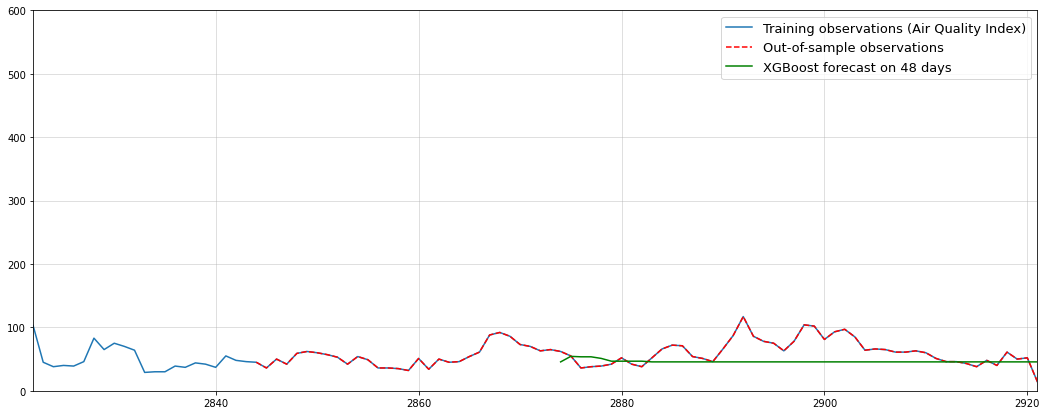

INFO:pycodestyle:6:80: E501 line too long (84 > 79 characters)
INFO:pycodestyle:7:80: E501 line too long (97 > 79 characters)
INFO:pycodestyle:8:80: E501 line too long (103 > 79 characters)


In [18]:
# Визуализируем
plt.figure(figsize=(18, 7))
plt.ylim([0, 600])
plt.grid(alpha=0.5)

plt.plot(data['aqi'].iloc[-100:], label="Training observations (Air Quality Index)")
plt.plot(y_test['aqi'].iloc[-100:], color="red", label="Out-of-sample observations", ls="dashed")
plt.plot(x_test.iloc[30:].index, samples[-1][0:48], color="green", label="XGBoost forecast on 48 days")


plt.legend(fontsize=13)
plt.margins(x=0)